# Vivarium: an interface and engine for integrative multi-scale modeling

Eran Agmon | Covert Lab Meeting | February 3, 2021

<table><tr>
<td> <img src="images/multiscale_ecoli.png" alt="Drawing" style="width: 700px;"/> </td>
<td> <img src="images/bigraph.png" alt="Drawing" style="width: 700px;"/> </td>
</tr></table>



## Overview
This notebook introduces the Vivarium interface protocol by working through a simple, qualitative example of transcription/translation, and iterating on model design to add more complexity.

## Outline
 1. Make a Process: minimal transcription
 2. Make a Composite: minimal transcription + translation
 3. Add Complexity: stochastic transcription, division
 4. Hierarchical embedding and Division
 5. Multi-paradigm Composites

<br><br>
**Note:** The included examples often skirt best coding practice in favor of simplicity. See Vivarium templates on github for better starting examples: https://github.com/vivarium-collective/vivarium-template

In [1]:
# # install vivarium libraries
# %%capture
# !pip install vivarium-core==0.1.6
# !pip install vivarium-cell==0.1.3

In [2]:
# to convert to presentation:
# jupyter nbconvert notebooks/vivarium_presentation_232021.ipynb --to slides

# to make printable slides:
# jupyter nbconvert --to slides --post serve notebooks/vivarium_presentation_232021.ipynb
# and convert the url to a format like: http://127.0.0.1:8000/<some-title>.slides.html?print-pdf

In [3]:
# Imports and Notebook Utilities
import os
import pylab as plt
import numpy as np
from scipy import constants

# Process, Deriver, and Composite base classes
from vivarium.core.process import (
    Process, 
    Deriver,
    Composite)
from vivarium.core.registry import process_registry

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables, save_fig_to_dir)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology
from vivarium_cell.plots.multibody_physics import plot_tags

AVOGADRO = constants.N_A * 1 / units.mol
    
# plotting configurations
topology_plot_config = {
    'settings': {'color_edges': False}, 
    'out_dir': 'out/'}

plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

# 1. Make a Process: minimal transcription

Transcription is the biological process by which RNA is synthesized from a DNA template.
Here, we define a model with a single mRNA species, $C$, transcribed from a single gene, $G$, at transcription rate $k_{tsc}$.
RNA also degrades at rate $k_{deg}$.

This can be represented by a chemical reaction network with the form:

<br>
<center>
$Gene_{G} \xrightarrow[]{k_{tsc}} Gene_{G} + RNA_{C} $ <br><br>
$RNA_{C} \xrightarrow[]{k_{deg}} \emptyset$
</center>

Which is written as the difference equation:

<br>
<center>
$\Delta RNA_{C} = (k_{tsc}[Gene_{G}] - k_{deg}[RNA_{C}]) \Delta t $ <br>
</center>

## Vivarium's basic elements
**Processes** can implement any kind of dynamical model - dynamic flux balance analysis, differential equation, stochastic process, Boolean logic, etc. \
**Stores** are databases of state variables read by the Processes, with methods for applying each Processes' updates.

<table><tr>
<td> <img src="images/process.png" alt="Drawing" style="width: 600;"/> </td>
<td> <img src="images/store.png" alt="Drawing" style="width: 600;"/> </td>
</tr></table>

### Process interface protocol
If standard modeling formats are an "HTML" for systems biology, we need an "interface protocol" such as TCP/IP serves for the internet -- a protocol for connecting separate systems into a complex and open-ended network that anyone can contribute to.

Making a dynamical model into a Vivarium Process requires the following protocol:
1. A *constructor* that accepts parameters and configures the model.
2. A *ports_schema* that declares the ports and their schema.
3. A *next_update* that runs the model and returns an update.

### Constructor
* `default` parameters are used in absense of an other provided parameters.
* The constructor's `parameters` arguments overrides the `default` parameters.

```python
class TSC(Process):
 
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}
    
    def __init__(self, parameters=None):
        super().__init__(parameters)
```

### Ports Schema
* Ports are the connections by which Process are wired to Stores. 
* `ports_schema` declares the ports, the variables that go through them, and how those variables operate.
* Here, `TSC` declares a port for `mRNA` with variable `C`, and a port for `DNA` with variable `G`.

```python
def ports_schema(self):
    return {
        'mRNA': {
            'C': {
                '_default': 0.0,
                '_updater': 'accumulate',
                '_divider': 'set',
                '_properties': {
                    'mw': 111.1 units.g / units.mol}},
        'DNA': {  
            'G': {
                '_default': 1.0}}
```

#### Advanced ports_schema

* dictionary comprehensions are useful for declaring schema for configured variables.

```python
def ports_schema(self):
    molecule_schema = {
        '_default': 0.0,
        '_emit': True}
    
    return {
        'molecules': {
            mol_id: molecule_schema 
            for mol_id in self.parameters['molecules']}}
```

#### Advanced ports_schema

* Schema methods can also be declared by passing in functions.
* The asymmetric_division divider makes molecules in the 'front' go to one daughter cell upon division, and those in the 'back' go to the other daughter.

```python
def asymmetric_division(value, topology):
    if 'front' in topology:
        return [value, 0.0]
    elif 'back' in topology:
        return [0.0, value]

def ports_schema(self):
    return {
        'front': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'front': ('molecule',)},
                }}},
        'back': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'back': ('molecule',)},
                }}}}
```

### Initial State
* Each Process MAY provide an `initial_state` method. This can be retrieved, reconfigured, and passed into a simulation.
* If left empty, a simulation initializes at the `'_default'` values.

```python
def initial_state(self, config):
    return {
        'DNA': {'G': 1.0},
        'mRNA': {'C': 0.0}}
```

### Update Method
* **Retrieve** the state variables through the ports.
* **Run** the model for the timestep’s duration.
* **Return** an update to the state variable through the ports.

```python
def next_update(self, states, timestep):

    # Retrieve
    G = states['DNA']['G']
    C = states['mRNA']['C']

    # Run
    dC = (self.ktsc * G - self.kdeg * C) * timestep

    # Return
    return {
        'mRNA': {
            'C': dC}}
```

# The Tsc Process

In [4]:
class TSC(Process):
    
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        
    def ports_schema(self):
        return {
            'DNA': {  
                'G': {
                    '_default': 1,         
                    '_updater': 'accumulate',
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 1,
                    '_updater': 'accumulate',
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        G = states['DNA']['G']
        C = states['mRNA']['C']
        dC = (self.parameters['ktsc'] * G - self.parameters['kdeg'] * C) * timestep
        return {
            'mRNA': {
                'C': dC}}

## Plot Tsc topology

Writing out/tsc_topology.pdf


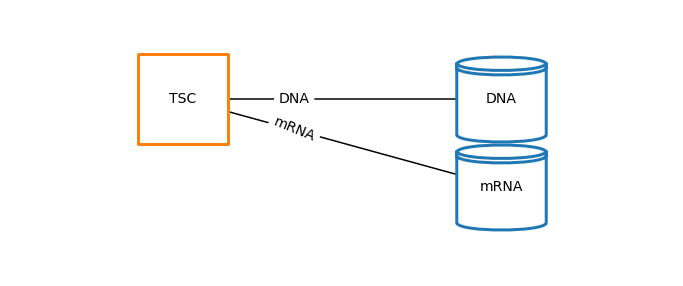

In [5]:
plot_topology(TSC(), filename='tsc_topology.pdf', **topology_plot_config)

## Run TSC

In [6]:
# tsc configuration
tsc_config = {'time_step': 10}
tsc_sim_settings = {
    'total_time': 10000,
    'experiment_id': 'TSC'}
tsc_plot_config = {
    'variables':[('mRNA','C'), ('DNA','G')],
    'filename': 'tsc_output.pdf',
    **plot_var_config}


Experiment ID: TSC
Created: 02/06/2021 at 10:50:45
Completed in 0.050973 seconds
Writing out/tsc_output.pdf


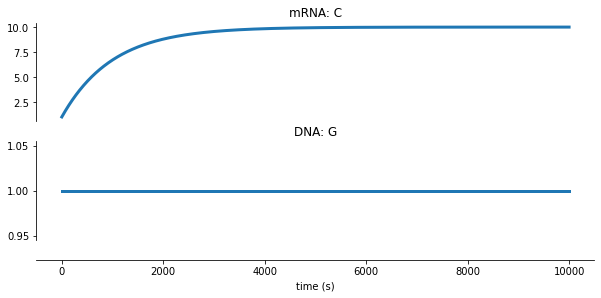

In [7]:
# initialize
tsc_process = TSC(tsc_config)

# run
tsc_output = simulate_process_in_experiment(tsc_process, tsc_sim_settings)

# plot
fig = plot_variables(tsc_output,  **tsc_plot_config)

## **Trl**: a deterministic translation process

Translation is the biological process by which protein is synthesized with an mRNA template.
Here, we define a model with a single protein species, $Protein_{X}$, transcribed from a single gene, $RNA_{C}$, at translation rate $k_{trl}$.
Protein also degrades at rate $k_{deg}$.

This can be represented by a chemical reaction network with the form:
* $RNA_{C} \xrightarrow[]{k_{trl}} RNA_{C} + Protein_{X} $ 
* $Protein_{X} \xrightarrow[]{k_{deg}} \emptyset$


In [8]:
class TRL(Process):

    defaults = {
        'ktrl': 1e-2,
        'kdeg': 1e-4}

    def ports_schema(self):
        return {
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_divider': 'split',
                    '_emit': True}},
            'Protein': {
                'X': {
                    '_default': 1.0,
                    '_divider': 'split',
                    '_emit': True}}}

    def next_update(self, timestep, states):
        C = states['mRNA']['C']
        X = states['Protein']['X']
        dX = (self.parameters['ktrl'] * C - self.parameters['kdeg'] * X) * timestep
        return {
            'Protein': {
                'X': dX}}
    

### Run Trl

In [9]:
# trl configuration
trl_config = {'time_step': 10}
trl_sim_settings = {
    'total_time': 10000,
    'experiment_id': 'TRL'}
trl_plot_config = {
    'variables':[('Protein','X'), ('mRNA','C')],
    'filename': 'trl_output.pdf',
    **plot_var_config}


Experiment ID: TRL
Created: 02/06/2021 at 10:50:46
Completed in 0.048675 seconds
Writing out/trl_output.pdf


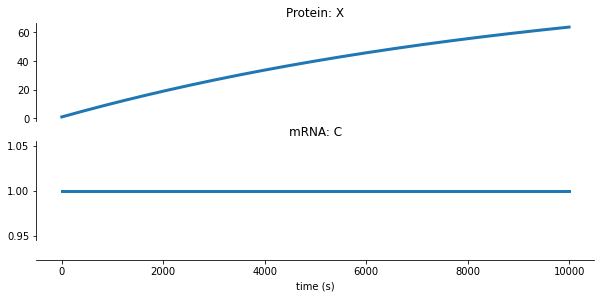

In [10]:
# construct a TRL Process
trl_process = TRL(trl_config)
 
# run it via the helper function simulate_process_in_experiment
trl_output = simulate_process_in_experiment(trl_process, trl_sim_settings)
 
# plot the output
fig = plot_variables(trl_output, **trl_plot_config)

# 2. Make a Composite

A **Composite** is a set of Processes and Stores. Vivarium constructs the Stores from the Processes's port_schema methods and wires them up as instructed by a **Topology**. The only communication between Processes is through variables in shared Stores.

<center><img src="images/composite.png" width=600/></center>

## **TscTrl**: a transcription/translation composite

We demonstrate composition by combining the `TSC` and `TRL` processes.

### Composition protocol

Composers for generating composites are implemented with the protocol:
1. A *constructor* that accepts configuration data, which can override the consituent Processes' default parameters.
1. A *generate_processes* method that constructs the Processes, passing model parameters as needed.
2. A *generate_topology* method that returns the Topology definition which tells Vivarium how to wire up the Processes to Stores.

### composite constructor

```python
class TscTrl(Composite):
    
    defaults = {
        'TSC': {
            'ktsc': 1e-2},
        'TRL': {
            'ktrl': 1e-3}}
    
    def __init__(self, config=None):
        super().__init__(config)
```

### generate processes
* Here, `generate_processes()` initializes a `TSC` Process and a `TRL` Process.

```python
def generate_processes(self, config):
    return {
        'TSC': TSC(config['TSC']),
        'TRL': TRL(config['TRL'])}
```

### generate topology
* Here, `generate_topology()` returns the Topology definition that wires these Processes together with 3 Stores, one of them shared.

```python
def generate_topology(self, config):
    return {
        'TSC': {
            'DNA': ('DNA',),     # connect TSC's 'DNA' Port to a 'DNA' Store
            'mRNA': ('mRNA',)},  # connect TSC's 'mRNA' Port to a 'mRNA' Store
        'TRL': {
            'mRNA': ('mRNA',),   # connect TRL's 'mRNA' Port to the same 'mRNA' Store
            'Protein': ('Protein',)}}
```

#### Advanced generate topology

* **embedding in a hierarchy**: to connect to sub-stores in a hierarchy, declare the path through each substore, as done to 'lipids'.
    * To connect to supra-stores use `'..'` for each level up, as done to `'external'`.
* **splitting ports**: One port can connect to multiple stores by specifying the path for each variable, as is done to `'transport'`.
    * This can be used to re-map variable names, for integration of different models.

```python
def generate_topology(config):
    return {
        'process_1': {
            'lipids': ('organelle', 'membrane', 'lipid'),
            'external': ('..', 'environment'),
            'transport': {
                'glucose_external': ('external', 'glucose'),
                'glucose_internal': ('internal', 'glucose'),
            }
        }}
```

### The TscTrl Composite

In [11]:
class TscTrl(Composite):
    
    defaults = {
        'TSC': {'time_step': 10},
        'TRL': {'time_step': 10}}

    def generate_processes(self, config):
        return {
            'TSC': TSC(config['TSC']),
            'TRL': TRL(config['TRL'])}

    def generate_topology(self, config):
        return {
            'TSC': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA',)},
            'TRL': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',)}}
    

### Plot TscTrl topology

Writing out/tsc_trl_topology.pdf


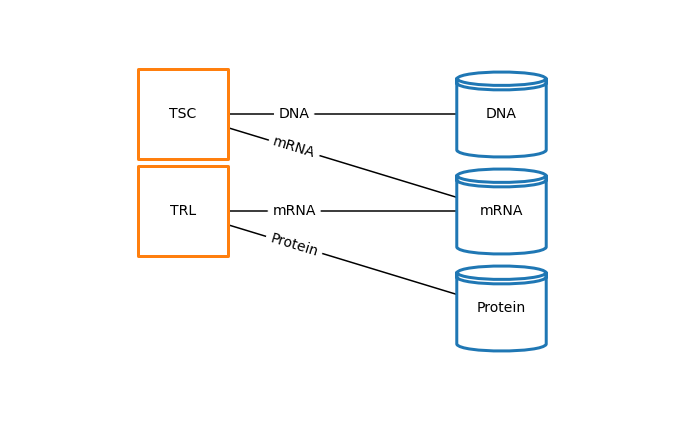

In [12]:
plot_topology(TscTrl(), filename='tsc_trl_topology.pdf', **topology_plot_config)

### run TscTrl

In [13]:
# tsc_trl configuration
tsc_trl_config = {}
tsc_trl_exp_settings = {'experiment_id': 'TscTrl'}
tsc_trl_plot_config = {
    'variables':[('Protein','X'), ('mRNA','C'), ('DNA','G')],
    'filename': 'tsc_trl_output.pdf',
    **plot_var_config}


Experiment ID: TscTrl
Created: 02/06/2021 at 10:50:46
Completed in 0.079668 seconds
Writing out/tsc_trl_output.pdf


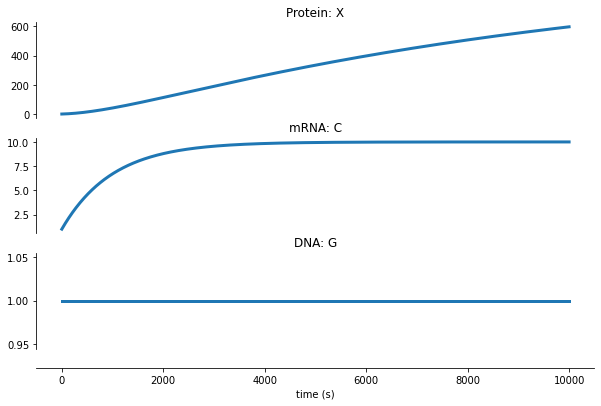

In [14]:
# construct TscTrl
tsc_trl_composite = TscTrl(tsc_trl_config)

# make the experiment
tsc_trl_experiment = compartment_in_experiment(tsc_trl_composite, tsc_trl_exp_settings)

# run it and retrieve the data that was emitted to the simulation log
tsc_trl_experiment.update(10000)
tsc_trl_output = tsc_trl_experiment.emitter.get_timeseries()

# plot the output
fig = plot_variables(tsc_trl_output, **tsc_trl_plot_config)

# 3. Add Complexity 

Process modularity allows modelers to iterate on model design by swapping out different models.
We demonstrated this by replacing the deterministic Transcription Process with a Stochastic Transcription Process. 

Stochastic transcription requires variable timesteps, which Vivarium accomodates with multi-timestepping.
<center><img src="images/dynamics.png" width=900/></center>

## **StochasticTsc**: a stochastic transcription process
This process uses the [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm) in its `next_update()` method.

In [15]:
class StochasticTSC(Process):
 
    defaults = {
        'time_step': 1,
        'ktsc': 5e0,
        'kdeg': 1e-1}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.ktsc = self.parameters['ktsc']
        self.kdeg = self.parameters['kdeg']
        self.stoichiometry = np.array([[0, 1], [0, -1]])
        self.time_remaining = 0.0

    def next_timestep(self, X):

        # Calculate propensities
        propensities = [self.ktsc * X[0], self.kdeg * X[1]]
        prop_sum = sum(propensities)

        # The wait time is distributed exponentially
        wait_time = np.random.exponential(scale=prop_sum)

        return wait_time
    
    def ports_schema(self):
        return {
            'DNA': {
                'G': {
                    '_default': 1.0,
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_emit': True}}}

    def gillespie(self, X, dT):
      t = 0.0
      while t < dT + self.time_remaining:
          # Calculate propensities
          propensities = [self.ktsc * X[0], self.kdeg * X[1]]
          prop_sum = sum(propensities)

          # The wait time is distributed exponentially
          wait_time = np.random.exponential(scale=prop_sum)

          # Reached the end of the simulation interval?
          if wait_time + t >= dT:
              self.time_remaining = dT - t  # save the unaccounted sim time
              break

          t += wait_time

          # Choose the next reaction
          r_rxn = np.random.random()
          for i in range(len(propensities)):
              if r_rxn < propensities[i] / prop_sum:
                  # This means propensity i fires
                  break
          X += self.stoichiometry[i]

      return X

    def next_update(self, timestep, states):

        # retrieve the state values
        G = states['DNA']['G']
        C = states['mRNA']['C']

        # apply the mechanism
        new_state = self.gillespie(
            np.array([G, C]), 
            timestep)

        # get delta mRNA
        C1 = new_state[1]
        dC = C1 - C

        # return an update
        return {
            'mRNA': {
                'C': dC}}


## Auxiliary Processes
* Connecting different Processes may require addition 'helper' Processes to make conversions and adapt their unique requirements different values.
* Derivers are a subclass of Process that runs after the other dynamic Processes and derives some states from others.

A **concentration deriver** convert the counts of the stochastic process to concentrations. This is available in the `process_registry`
```python
concentrations_deriver = process_registry.access('concentrations_deriver')
```

## Use composite.merge() to add processes
The concentration deriver is added directly to `StochasticTSC` by using the `merge()` method.

Here is the topology before merge:

Writing out/stochastic_tsc_topology_before.pdf


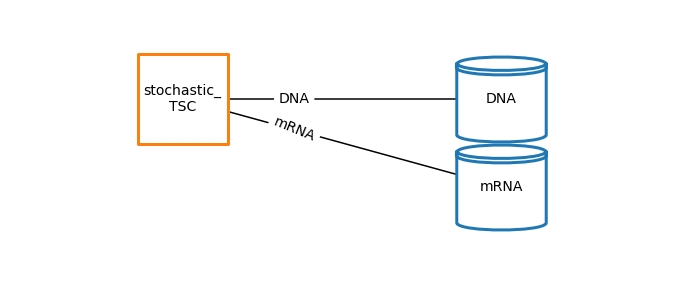

In [16]:
# make a stochastic transcription process
stochastic_tsc = StochasticTSC({'name': 'stochastic_TSC'})

# plot topology before merge
plot_topology(stochastic_tsc, filename='stochastic_tsc_topology_before.pdf', **topology_plot_config)

Here is the merge operation and resulting topology:

Writing out/stochastic_tsc_topology_after.pdf


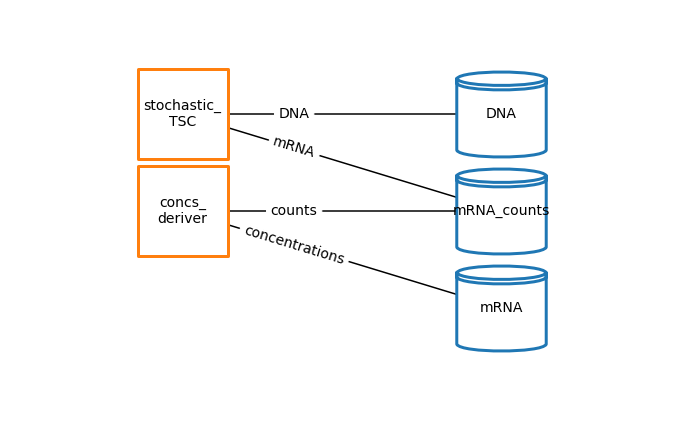

In [17]:
# perform merge
concentrations_deriver = process_registry.access('concentrations_deriver')
stochastic_tsc.merge(
    processes={'concs_deriver': concentrations_deriver({'concentration_keys': ['C']})},
    topology={
        'stochastic_TSC': {
            'mRNA': ('mRNA_counts',)},
        'concs_deriver': {
          'counts': ('mRNA_counts',),
          'concentrations': ('mRNA',)}},
    schema_override={
        'concs_deriver': {'concentrations': {'C': {'_emit': True}}}})

# plot topology after merge
plot_topology(stochastic_tsc, filename='stochastic_tsc_topology_after.pdf', **topology_plot_config)

In [18]:
# run stochastic_tsc configuration
stochastic_tsc_exp_settings = {'experiment_id': 'stochastic_tsc'}
stochastic_tsc_plot_config = {
    'variables':[('mRNA', ('C', 'millimole / liter')), ('DNA', 'G')],
    'filename': 'stochastic_tsc_output.pdf',
    **plot_var_config}


Experiment ID: stochastic_tsc
Created: 02/06/2021 at 10:50:47
Completed in 0.151673 seconds
Writing out/stochastic_tsc_output.pdf


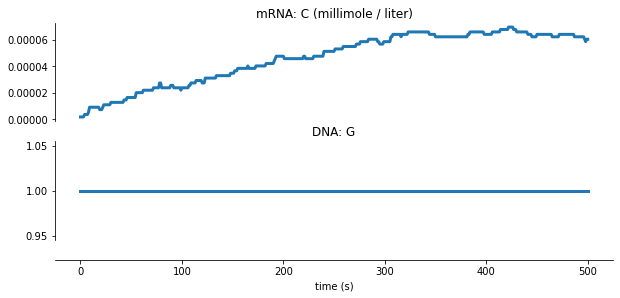

In [19]:
# make the experiment
stochastic_tsc_experiment = compartment_in_experiment(
    stochastic_tsc, 
    stochastic_tsc_exp_settings)

# run experiment
stochastic_tsc_experiment.update(500)

# get output and plot
stochastic_tsc_output = stochastic_tsc_experiment.emitter.get_timeseries()
fig = plot_variables(stochastic_tsc_output, **stochastic_tsc_plot_config)

## Add StochasticTsc to TscTrl Composite

This makes a new TscTrl composite, with `StochasticTSC` in place of the deterministic `TSC` Process.

In [20]:

class TrlConcentration(TRL):
    """rescale mRNA"""
    def next_update(self, timestep, states):
        states['mRNA']['C'] = states['mRNA']['C'].magnitude * 1e5  
        return super().next_update(timestep, states)
        

class StochasticTscTrl(Composite):
    defaults = {
        'stochastic_TSC': {'time_step': 10},
        'TRL': {'time_step': 10}}
    
    def generate_processes(self, config):
        concentrations_deriver = process_registry.access('concentrations_deriver')
        return {
            'stochastic_TSC': StochasticTSC(config['stochastic_TSC']),
            'TRL': TrlConcentration(config['TRL']),
            'concs': concentrations_deriver({'concentration_keys': ['C']})}

    def generate_topology(self, config):
        return {
            'stochastic_TSC': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA_counts',)
                },
            'TRL': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',)
                },
            'concs': {
                'counts': ('mRNA_counts',),
                'concentrations': ('mRNA',)
            }
        }
    

In [21]:
# plot topology after merge
stochastic_tsc_trl = StochasticTscTrl()
fig = plot_topology(
    stochastic_tsc_trl, 
    filename='stochastic_tsc_trl_topology.pdf', 
    **topology_plot_config)

Writing out/stochastic_tsc_trl_topology.pdf


### Simulate the StochasticTscTrl composite

In [22]:
exp_settings = {
    'experiment_id': 'stochastic_tsc_trl'}

stoch_plot_config = {
    'variables':[('Protein','X'), ('mRNA',('C', 'millimole / liter')), ('DNA','G')],
    'filename': 'stochastic_tsc_trl_output.pdf',
    **plot_var_config}


Experiment ID: stochastic_tsc_trl
Created: 02/06/2021 at 10:50:48
Completed in 0.358944 seconds
Writing out/stochastic_tsc_trl_output.pdf


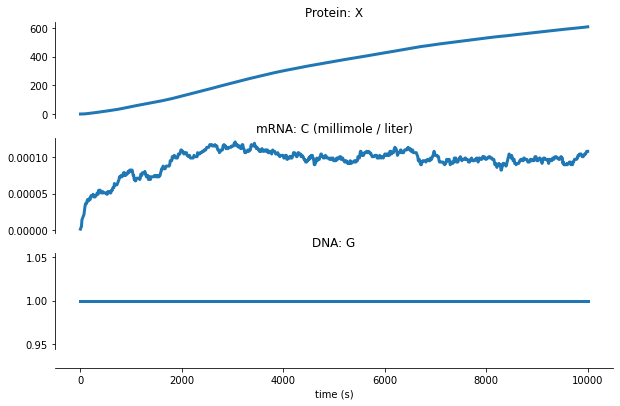

In [23]:
# make the experiment
stoch_experiment = compartment_in_experiment(stochastic_tsc_trl, exp_settings)

# simulate and retrieve the data
stoch_experiment.update(10000)
data = stoch_experiment.emitter.get_timeseries()

# plot output
fig = plot_variables(data, **stoch_plot_config)

# 4. Growth and Division

We here extend the Transcription/Translation model with division. This require many instances of the processes to run simultaneously in a single simulation. To support such phenomena, Vivarium adopts an agent-based modeling bigraphical formalism, with embedded compartments that can spawn new compartments during runtime. 

<center><img src="images/tsc_trl_divide.png" width=700/></center>

## Hierarchical Embedding

To support this requirement, Processes can be embedded in a hierarchical representation of embedded compartments.
Vivarium uses a bigraph formalism -- a graph with embeddable nodes that can be placed within other nodes.

<center><img src="images/embedding.png" width=900/></center>

## Hierarchy updates

The structure of a hierarchy has its own type of constructive dynamics with formation/destruction, merging/division, engulfing/expelling of compartments

<center><img src="images/constructive.png" width=900/></center>

## Mass deriver

In [24]:

def calculate_mass(value, path, node):
    if 'mw' in node.properties:
        count = node.value
        mw = node.properties['mw']
        mol = count / AVOGADRO
        added_mass = (mw * mol).to('fg')
        return value + added_mass
    else:
        return value

class Mass(Deriver):
    ''' Converts molecule counts to total compartment mass'''

    defaults = {
        'from_path': ('..', '..'),
        'molecular_weight': {
            'RNA': 1e10 * units.g / units.mol,
            'Protein': 1e10 * units.g / units.mol
        }}

    def ports_schema(self):
        return {
            'global': {
                'mass': {
                    '_default': 1 * units.fg,
                    '_updater': 'set',
                    '_emit': True},
                },
            'molecules': {
                'DNA': {'*': {}},
                'RNA': {
                    'C': {
                        '_properties': {
                            'mw': self.parameters['molecular_weight']['RNA']
                            }}},
                'Protein': {
                    'X': {
                      '_properties': {
                          'mw': self.parameters['molecular_weight']['Protein']
                          }}}}}
    
    def next_update(self, timestep, states):
        return {
            'global': {
                'mass': {
                    '_reduce': {
                        'reducer': calculate_mass,
                        'from': self.parameters['from_path'],
                        'initial': 0.0}}}}




class ColonyMass(Mass):
    defaults = {
        'from_path': ('..', '..', 'agents')}

    def ports_schema(self):
        return {
            'global': {
                'mass': {
                    '_default': 1 * units.fg,
                    '_updater': 'set',
                    '_emit': True}}}
    

In [25]:
# add imported division processes
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
from vivarium_cell.processes.derive_globals import DeriveGlobals

 
class TscTrlDivision(Composite):
    
    defaults = {
        'stochastic_TSC': {'time_step': 10},
        'TRL': {'time_step': 10},
        'agent_id': np.random.randint(0,100),
        'divide_condition': {
            'threshold': 2000.0 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
        }

    def generate_processes(self, config):
        division_config = dict(
            daughter_path=config['daughter_path'], 
            agent_id=config['agent_id'], 
            generator=self)
        
        return {
            'stochastic_TSC': StochasticTSC(config['stochastic_TSC']),
            'TRL': TRL(config['TRL']),
            'mass': Mass({}),
            'globals_deriver': DeriveGlobals({}),
            'divide_condition': DivideCondition(config['divide_condition']),
            'division': MetaDivision(division_config)}

    def generate_topology(self, config):
        return {
            'stochastic_TSC': {
                'DNA': ('DNA',),
                'mRNA': ('RNA',)},
            'TRL': {
                'mRNA': ('RNA',),
                'Protein': ('Protein',)},
            'mass': {
                'global': ('boundary',),
                'molecules': {
                    'DNA': ('DNA',),
                    'RNA': ('RNA',),
                    'Protein': ('Protein',)}},
            'globals_deriver': {
                'global': ('boundary',)},
            'divide_condition': {
                'variable': ('boundary', 'mass',),
                'divide': ('boundary', 'divide',)},
            'division': {
                'global': ('boundary',),
                'agents': config['agents_path']}}
  

In [26]:
# configure hierarchy
# agent config
agent_id = '1'
agent_config = {
    'agent_id': agent_id,
    'stochastic_TSC': {
        'ktsc': 2e0,
        'kdeg': 2e-1,
        },
    'TRL': {
        'ktrl': 5e-3,
        'kdeg': 1e-4,
        }}

# environment config
env_config = {}

# initial state
hierarchy_initial_state = {
    'agents': {
        agent_id: {
            'DNA': {'G': 1},
            'RNA': {'C': 5},
            'Protein': {'X': 50}}}}
hierarchy_exp_settings = {
    'initial_state': hierarchy_initial_state,
    'experiment_id': 'spatial_environment'}

# plot config
hierarchy_plot_settings = {
    'include_paths': [
        ('boundary', 'mass'),
        ('RNA', 'C'),
        ('DNA', 'G'),
        ('Protein', 'X'),
        ],
    'column_width': 10,
    'row_height': 1.5,
    'title_on_y_axis': True,
    'stack_column': True,
    'tick_label_size': 10,
    'title_size': 10}

colony_plot_config = {
    'variables':[('global', ('mass', 'femtogram'))],
    'filename': 'colony_growth.pdf',
    **plot_var_config}

## Compose a hierarchy

In [27]:
hierarchy = {
    FACTORY_KEY: {
        'type': ColonyMass,
        'config': env_config},
    'agents': {
        agent_id: {
            FACTORY_KEY: {
                'type': TscTrlDivision,
                'config': agent_config}}}}

# configure experiment with helper function compose_experiment()
hierarchy_experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=hierarchy_exp_settings)



Experiment ID: spatial_environment
Created: 02/06/2021 at 10:50:49


In [28]:
# run the experiment
hierarchy_experiment.update(6000)

# retrieve the data
hierarchy_data = hierarchy_experiment.emitter.get_data_unitless()
gd_timeseries = hierarchy_experiment.emitter.get_timeseries()

Completed in 7.10 seconds


Writing out/growth_division_output.pdf


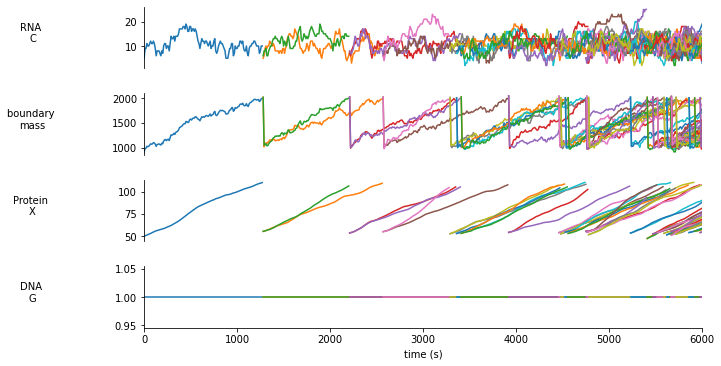

In [29]:
fig = plot_agents_multigen(hierarchy_data, hierarchy_plot_settings)
save_fig_to_dir(fig, 'growth_division_output.pdf')

## Colony-level metrics

Writing out/colony_growth.pdf


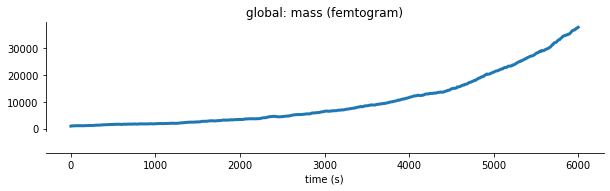

In [30]:

fig = plot_variables(gd_timeseries, **colony_plot_config)

# 5. Multi-paradigm composites

Vivarium is a powerful tool for combining previously-isolated frameworks in computational biology.
This section combines flux balance analysis (FBA), chemical reaction networks (CRNs), and a physics engine, to simulate many individual cells in a spatial environment.

<center><img src="images/multi_paradigm.png" width=900/></center>

In [2]:
import os
import pylab as plt
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

# vivarium-core imports
from vivarium.core.process import Process, Deriver, Composite
from vivarium.library.units import units
from vivarium.core.composition import (
    compartment_in_experiment,
    simulate_compartment_in_experiment,
    simulate_process_in_experiment,
    compose_experiment,
    FACTORY_KEY)
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

# vivarium-cobra imports
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth)

# get the configuration for the iAF1260b BiGG model
config = get_iAF1260b_config()
config.update({'time_step': 10})
iAF1260b_config = {'cobra': config}   

# vivarium-bioscrape imports
from vivarium_bioscrape.processes.bioscrape import Bioscrape

# vivarium-multibody imports
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import (
    agent_body_config, 
    volume_from_length)
from vivarium_multibody.composites.lattice import Lattice, make_lattice_config
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors)

# plotting
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# plotting configuration
plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

# cobra configurations
cobra_plot_config = {
    'variables':[
        {'variable': ('external', 'glc__D_e'), 'color': 'k', 'display': 'exernal glucose (mmol/L)'}, 
        ('external', 'co2_e'), 
        ('internal_counts', 'glu__L_c'), 
        ('global', ('mass', 'femtogram'))],
    'filename': 'cobra_out.pdf',
    **plot_var_config}


## **Paradigm 1**: Flux Balance Analysis with COBRA

[Constraint-based reconstruction and analysis (COBRA)](https://cobrapy.readthedocs.io/en/latest/) is a popular FBA solver.

The [vivarium-cobra library](https://github.com/vivarium-collective/vivarium-cobra) provides a Vivarium wrapper process for COBRA:
 ```
 pip install vivarium-cobra
 ```

In [32]:
def plot_metabolism(data):

    ncol = 2

    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})

    # initialize subplots
    n_rows = 3
    n_cols = 1
    fig = plt.figure(figsize=(n_cols * 10, n_rows * 2))
    grid = plt.GridSpec(n_rows, n_cols)

    time_vec = data['time']

    # external
    ax = fig.add_subplot(grid[0, 0])
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label=mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)

    # internal
    ax = fig.add_subplot(grid[1, 0])
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label=mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)

    
    # mass
    ax = fig.add_subplot(grid[2, 0])
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label='mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    fig.tight_layout()
    
    
    return fig

In [33]:
# load iAF1260b into CobraComposite
dynamic_fba = CobraComposite(iAF1260b_config)

# get the model's initial state
initial_state = dynamic_fba.initial_state({}) 
cobra_sim_settings = {
    'initial_state': initial_state,
    'total_time': 2000}

# run simulation
cobra_timeseries = simulate_compartment_in_experiment(dynamic_fba, cobra_sim_settings)


Experiment ID: 4a74c63c-68ac-11eb-a7bb-acde48001122
Created: 02/06/2021 at 10:51:15
Completed in 25.27 seconds


### COBRA composite

 * Additional auxiliary processes come bundled together with COBRA to convert molecular counts to mass, and mass to volume and other cell shape.
 * A fields deriver supports simplified pluggability into spatial environments.

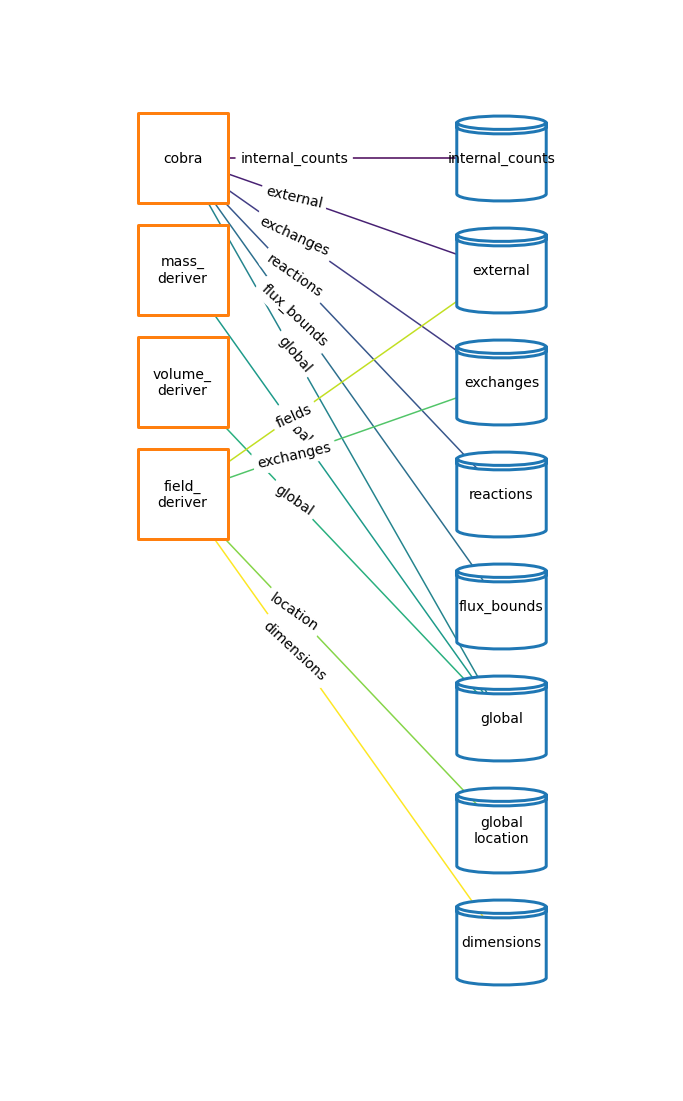

In [34]:
fig = plot_topology(dynamic_fba)

### BIGG models
* The COBRA process can load [BiGG metabolic models](http://bigg.ucsd.edu) -- over 100 models are available, including dozens of *E. coli* strains. 
* Here, *iAF1260b* is load, which has 2382 reactions, 1261 genes, and 166 metabolites.
* The objective function, with 67 molecules, is stored in internal pools. There are 299 external molecules -- of these, 19 (plotted) show dynamics in minimal conditions.

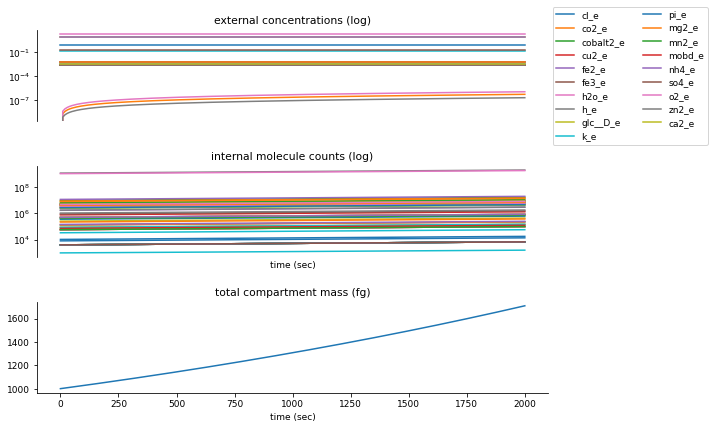

In [35]:
fig = plot_metabolism(cobra_timeseries)

Writing out/cobra_out.pdf


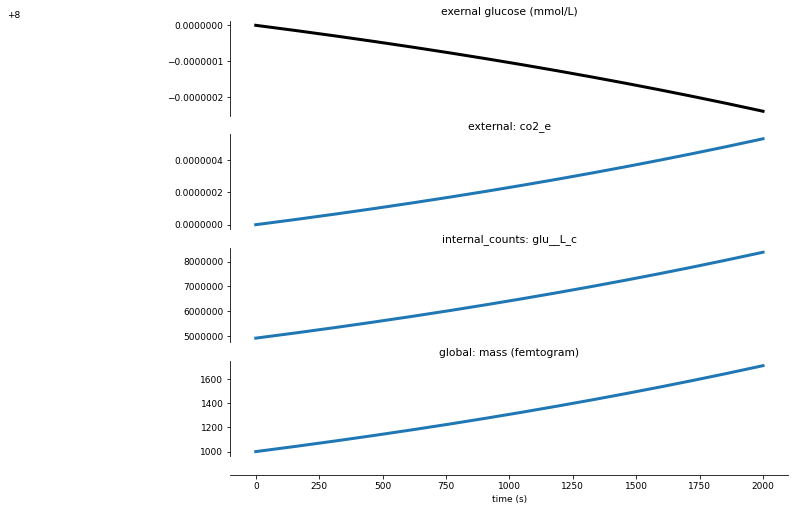

In [36]:
fig = plot_variables(cobra_timeseries, **cobra_plot_config)

## **Paradigm 2**: Chemical Reaction Network with Bioscrape

Bioscrape is an easily extensible and modular object-oriented framework for building and simulating CRNs.

The [vivarium-bioscrape library](https://github.com/vivarium-collective/vivarium-bioscrape) provides a Vivarium wrapper process for Bioscrape:
 ```
 pip install vivarium-bioscrape
 ```

### Bioscrape Process loads Systems Biology Markup Language (SBML) files

This provides access to the over 1000 reproducible and freely-accessible published models posted on [BioModels](http://www.ebi.ac.uk/biomodels/).

```python
class Bioscrape(Process):
    defaults = {
        'sbml_file': 'model.xml',
        'stochastic': False}

    def __init__(self, parameters=None):
        super(Bioscrape, self).__init__(parameters)
        self.model = Model(sbml_filename=self.parameters['sbml_file'])
```

In [37]:
from vivarium.core.composition import process_in_experiment
from vivarium_bioscrape.processes.bioscrape import Bioscrape

time_step = 1
total_time = 5000
bioscrape_variables = {
    'variables':[
        ('species', 'Glucose_external'), 
        ('species', 'Lactose_external'), 
        ('species', 'rna_M'), 
        ('species', 'protein_betaGal'),
        ('species', 'protein_Lactose_Permease')]}
deterministic_plot_config = {
    'filename': 'bioscrape_deterministic.pdf',
    **bioscrape_variables,
    **plot_var_config}
stochastic_plot_config = {
    'filename': 'bioscrape_stochastic.pdf',
    **bioscrape_variables,
    **plot_var_config}

### Deterministic simulation

```python
deterministic_process = Bioscrape({
    'sbml_file': '../Lac Operon Model/LacOperon_deterministic.xml'})
```

In [38]:
config = {
    'sbml_file': '../Lac Operon Model/LacOperon_deterministic.xml'}
deterministic_process = Bioscrape(config)
initial_state = deterministic_process.initial_state()
deterministic_experiment = process_in_experiment(deterministic_process, initial_state=initial_state)
deterministic_experiment.update(total_time)


Experiment ID: 5cc4565e-68ac-11eb-a7bb-acde48001122
Created: 02/06/2021 at 10:51:46
Completed in 4.32 seconds


Writing out/bioscrape_deterministic.pdf


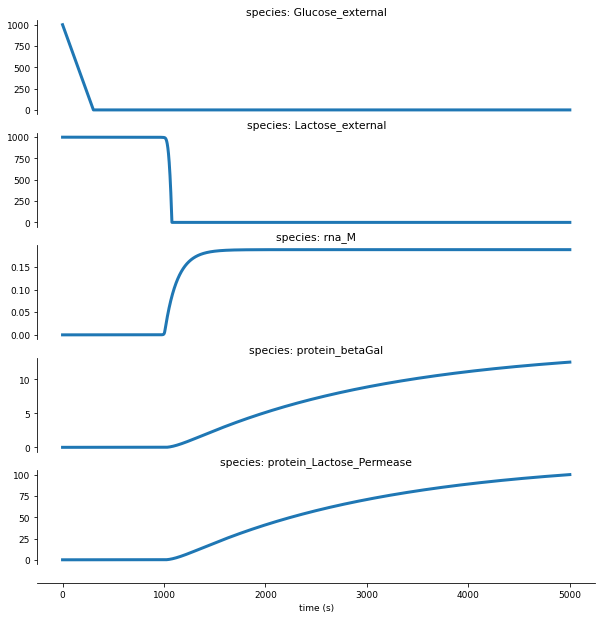

In [39]:
deterministic_timeseries = deterministic_experiment.emitter.get_timeseries()
fig = plot_variables(deterministic_timeseries, **deterministic_plot_config)

### Stochastic simulation

```python
stochastic_process = Bioscrape({
    'stochastic': True,
    'sbml_file': '../Lac Operon Model/LacOperon_stochastic.xml'})
```

<center><img src="images/bioscrape_stochastic.png" width=700/></center>

## **Paradigm 3**: Multibody physics with pymunk
[pymunk](multibody) is an open-source video game physics engine.
[vivarium-multibody](https://github.com/vivarium-collective/vivarium-multibody) provides a Vivarium wrapper process for pymunk, configured specifically for multi-cellular physics:
 ```
 pip install vivarium-multibody
 ```

In [3]:
total_time = 150
n_agents = 3
spatial_bounds = [60, 60]

# configure
agent_ids = [str(agent_id) for agent_id in range(n_agents)]
body_config = {'bounds': spatial_bounds, 'agent_ids': agent_ids}
multibody_config = {'bounds': spatial_bounds}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4,1),
        total_time=total_time,
        experiment_settings=experiment_settings)
multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

# make the snapshot plot function
time_vec = list(multibody_agents.keys()) 

# get fields and agent colors
multibody_field_range = get_field_range(multibody_fields, time_vec)
multibody_agent_colors = get_agent_colors(multibody_agents)

time_index_range = len(time_vec) -1

Writing out/multibody_snapshots.pdf


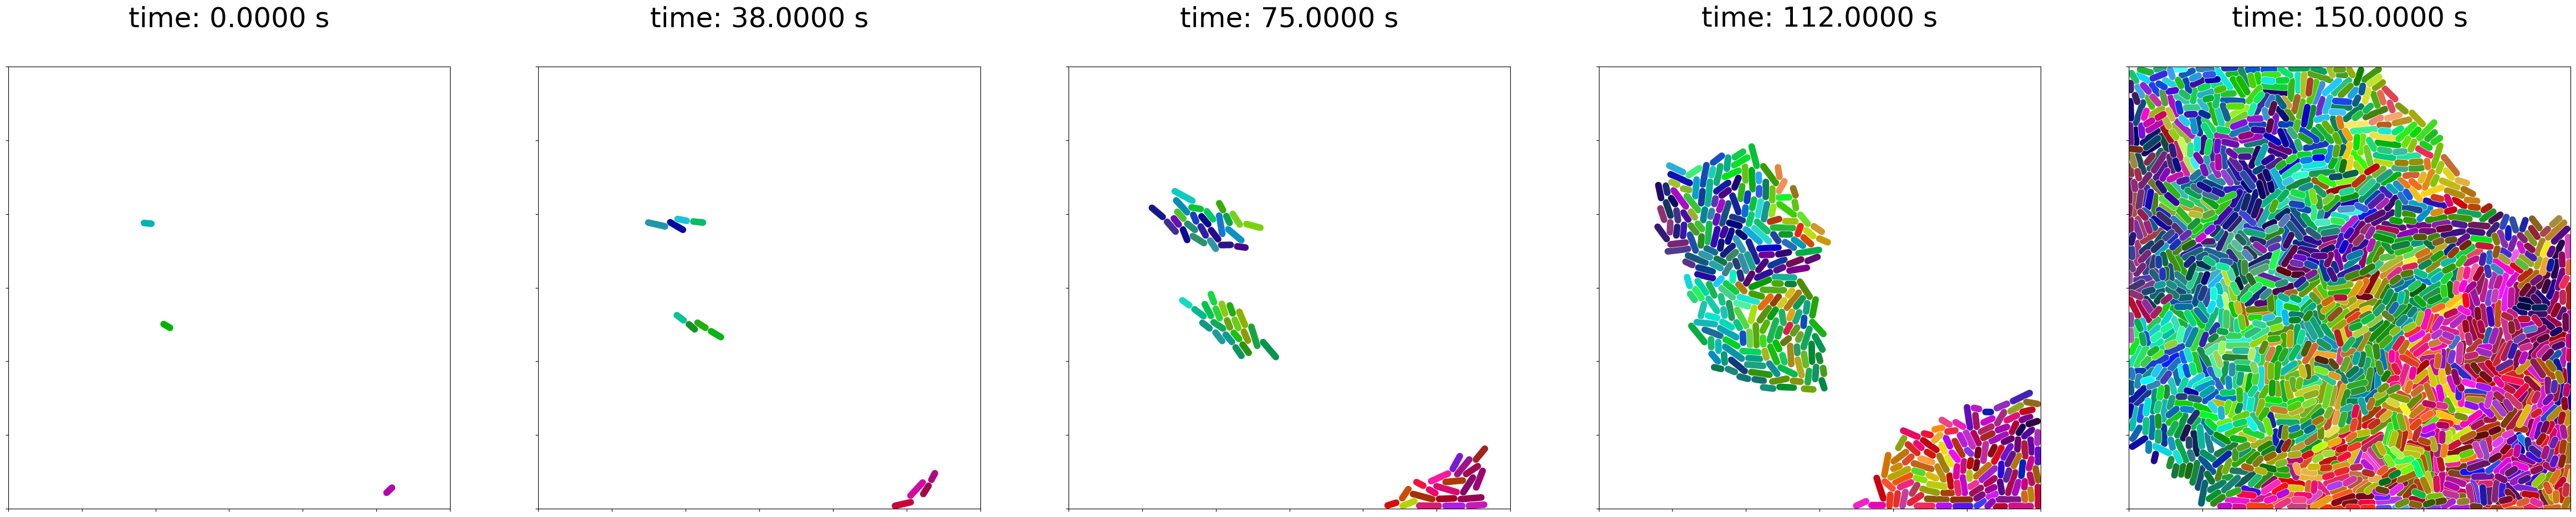

In [52]:
fig2 = plot_snapshots(
    bounds=spatial_bounds,
    agents=multibody_agents,
    fields=multibody_fields,
    n_snapshots=5
    )
save_fig_to_dir(fig2, 'multibody_snapshots.pdf')

In [41]:
# multibody_agent_colors = get_agent_colors(multibody_agents)

In [4]:
def plot_single_snapshot(t_index):   
    time_indices = np.array([t_index])
    snapshot_time = [time_vec[t_index]]
    fig = make_snapshots_figure(
        time_indices=time_indices,
        snapshot_times=snapshot_time,
        agents=multibody_agents,
        agent_colors=multibody_agent_colors,
        fields=multibody_fields,
        field_range=multibody_field_range,
        n_snapshots=1,
        bounds=spatial_bounds,
        default_font_size=12,
        plot_width=7)

interactive_plot = interactive(
    plot_single_snapshot, 
    t_index=widgets.IntSlider(min=0, max=time_index_range, step=2, value=0))

In [5]:
interactive_plot

interactive(children=(IntSlider(value=0, description='t_index', max=150, step=2), Output()), _dom_classes=('wi…

## **Integration**: BioscrapeCOBRA

This composite requires several adaptor processes and advanced topology methods.

In [44]:
class BioscrapeCOBRA(Composite):

    def generate_topology(self, config):

        topology = {
            'bioscrape': {
                # all species go to a species store on the base level,
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..', 'globals', 'biomass'),
                },
                'delta_species': ('delta_species',),
                'rates': ('rates',),
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('globals',),
            },
            'flux_deriver': {
                'deltas': ('delta_species',),
                'amounts': ('globals',),
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'
                # also connect biomass flux to the dilution rate
                'fluxes':
                    {
                        '_path': ('flux_bounds',),
                        'Lactose_consumed': ('EX_lac__D_e',),
                        'Glucose_internal': ('EX_glc__D_e',),
                        'biomass':('..', 'rates', 'k_dilution__',)
                    }
            },
            'mass_deriver': {
                'global': ('globals',),
            },
            'volume_deriver': {
                'global': ('globals',),
            },
            'biomass_adaptor': {
                'input': ('globals',),
                'output': ('globals',),
            }
        }
        if config['divide_on']:  # optional division
            agents_path = config['agents_path']

            # connect divide_condition to the mass variable
            topology.update({
                'divide_condition': {
                    'variable': ('globals', 'mass',),
                    'divide': ('globals', 'divide',),
                },
                'division': {
                    'global': ('globals',),
                    'agents': agents_path,
                },
            })
        return topology

## Stochastic LacY expression in a Lattice environment

<center><img src="images/integration.png" width=1300/></center>

# Acknowledgements


Co-authors on the Vivarium paper:\
&nbsp;Ryan Spangler, Christopher Skalnik, William Poole, Shayn Peirce, Jerry Morrison, and Markus Covert

<br>
<br>

<center><img src="images/covert_lab.png" width=800/></center><br>